In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from tabulate import tabulate
import mlflow
from sklearn.linear_model import SGDRegressor


path = 'SAMPLE_DATA_SET.xlsx'

# Read and load dataset
df= pd.read_excel(path, sheet_name=[0, 1])


INPUT DATA

In [2]:
X =df.get(0)
X = (X.iloc[:,1:]).values
X = X.T
print(X.shape)

(839, 444)


OUTPUT DATA

In [3]:
Y =df.get(1)
Y = (Y.iloc[:,:]).values
print(Y.shape)

(839, 2)


**LINEAR REGRESSION with SVD**

Ripartion: 0.05
Ripartion: 0.1
Ripartion: 0.15
Ripartion: 0.2
Ripartion: 0.25
Ripartion: 0.3
Ripartion: 0.35
Ripartion: 0.4
Ripartion: 0.45
Ripartion: 0.5
╔════════════════╦══════════════╦══════════════╦══════════════╦══════════════╦═══════════════╦═══════════════╦═════════╦═════════╗
║   Test size(%) ║   Best(MSE1) ║   Best(MSE2) ║   Mean(MSE1) ║   Mean(MSE2) ║     Var(MSE1) ║     Var(MSE2) ║   Seed1 ║   Seed2 ║
╠════════════════╬══════════════╬══════════════╬══════════════╬══════════════╬═══════════════╬═══════════════╬═════════╬═════════╣
║              5 ║      2.31376 ║      2.47491 ║  5.47104     ║   6.2038     ║   3.05192     ║   3.88951     ║      70 ║       8 ║
║             10 ║      3.30903 ║      4.18569 ║  6.11396     ║   6.70178    ║   2.03417     ║   2.4292      ║      34 ║      86 ║
║             15 ║      3.75571 ║      4.52331 ║  6.87818     ║   7.31521    ║   2.74071     ║   2.26154     ║      51 ║      72 ║
║             20 ║      4.9679  ║      5.35889 ║  7.62854  

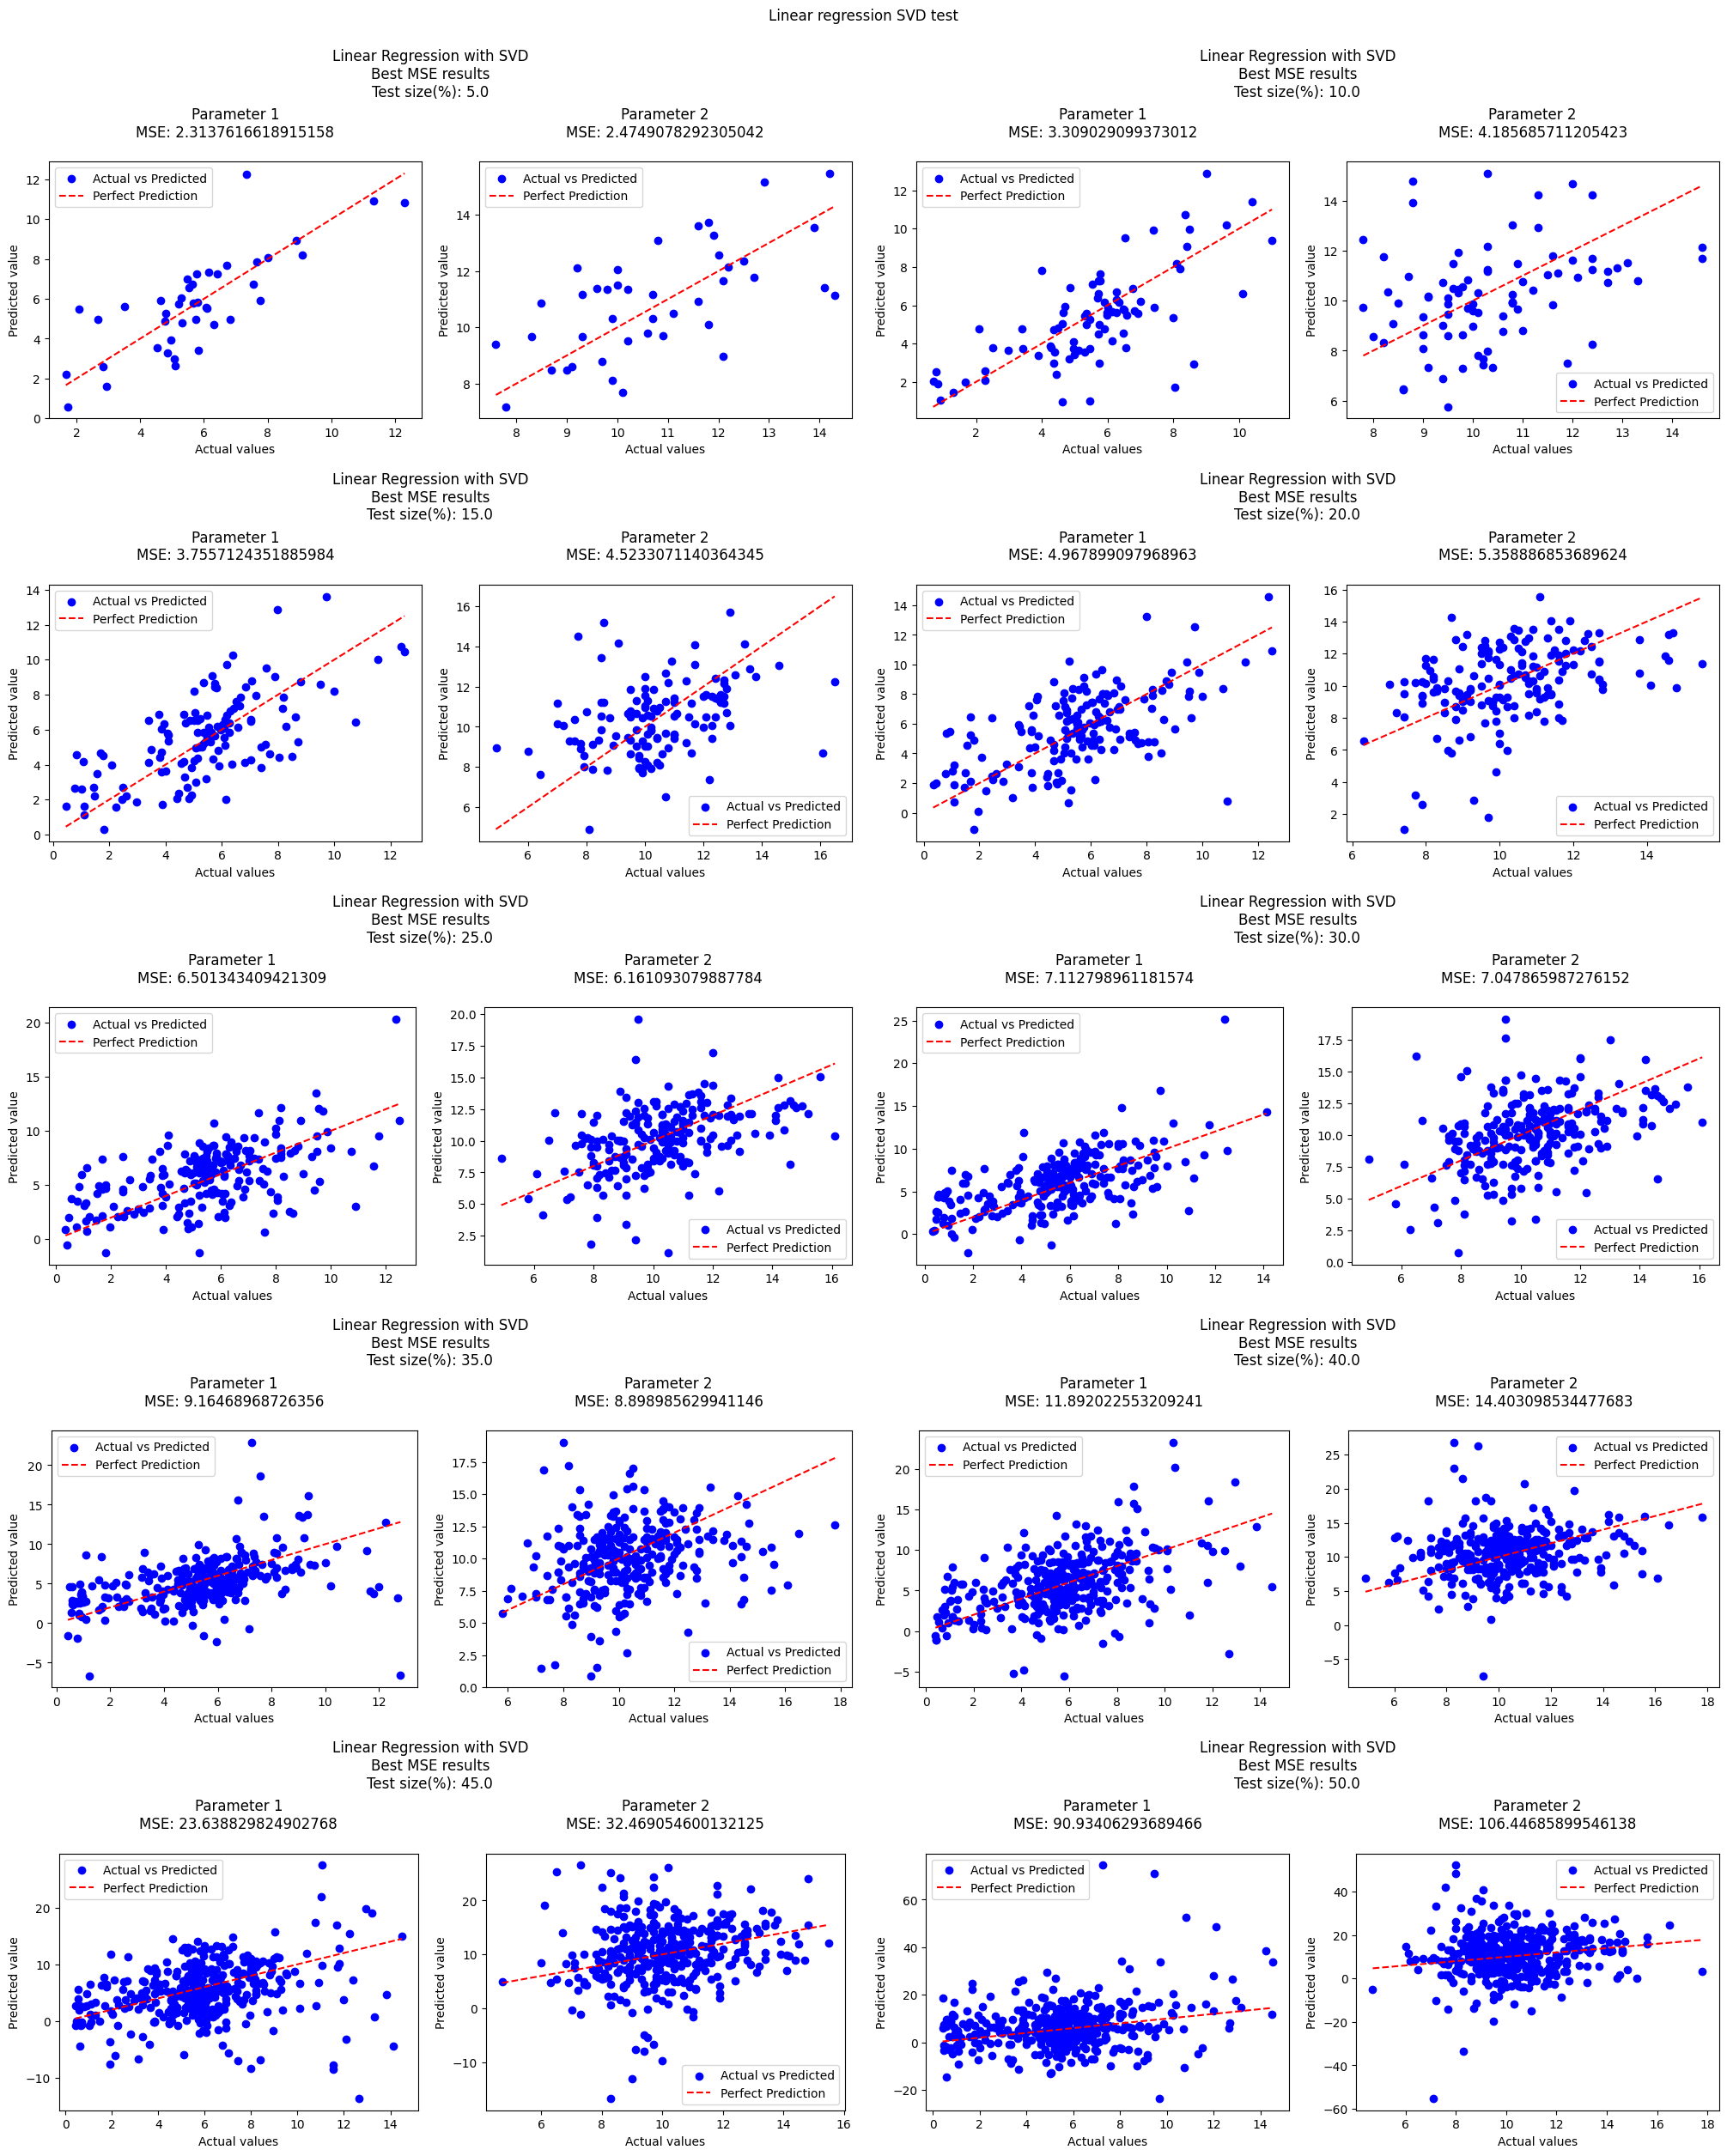

In [15]:

mlflow.set_experiment("Linear SVD Demetra")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartitions = [i/100 for i in range(5,55,5)]
results = [] 

# create 5x2 subfigs
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
fig.suptitle('Linear regression SVD test'+"\n")
subfigs = fig.subfigures(nrows=5, ncols=2).flatten()
k = 0

for ripartition in ripartitions:

    '''PARAM 1'''
    MSE_param1 = []
    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"seed":None}

    '''PARAM 2'''
    MSE_param2 = []
    best_MSE_2 = 100000000
    best_data_2 = {"Y_test":None, "Y_pred":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):

        print("Ripartion: " + str(ripartition))
        i = 0
        mlflow.log_param('ripartition', ripartition)
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
            regr = LinearRegression()
    
            # Train the model using the training sets
            regr.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_regr_svd = regr.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_regr_svd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_regr_svd
              best_data_1["seed"] = seeds[i]



        i = 0
        for i in range(trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
            regr = LinearRegression()
    
            # Train the model using the training sets
            regr.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_regr_svd = regr.predict(X_test)
    
            #save MSE of the second parameters
            MSE_param2.append(mean_squared_error(Y_test, Y_pred_regr_svd))
    
            #check if this is the best model in terms of MSE
            if MSE_param2[-1] < best_MSE_2:
              best_MSE_2 = MSE_param2[-1]
              best_data_2["Y_test"] = Y_test
              best_data_2["Y_pred"] = Y_pred_regr_svd
              best_data_2["seed"] = seeds[i]
                
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Best_MSE2", best_MSE_2)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Mean_MSE2", np.mean(MSE_param2))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        mlflow.log_metric("Var_MSE2", np.var(MSE_param2))
        
    results.append([str(ripartition * 100), str(best_MSE_1), str(best_MSE_2),
                    (np.mean(MSE_param1)), str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2)),
                    best_data_1["seed"],best_data_2["seed"]])
    
    '''PLOT THE BEST MODELS'''
    subfigs[k].suptitle(
        "Linear Regression with SVD" + "\n" + "Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    # create 1x2 subplots per subfig
    axs = subfigs[k].subplots(nrows=1, ncols=2)
    axs[0].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[0].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[0].legend()
    axs[0].set_xlabel("Actual values")
    axs[0].set_ylabel("Predicted value")
    axs[0].set_title("Parameter 1" + "\n" + "MSE: " + str(min(MSE_param1)) + "\n" )

    axs[1].scatter(best_data_2["Y_test"], best_data_2["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[1].plot([min(best_data_2["Y_test"]), max(best_data_2["Y_test"])],
                [min(best_data_2["Y_test"]), max(best_data_2["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[1].legend()
    axs[1].set_xlabel("Actual values")
    axs[1].set_ylabel("Predicted value")
    axs[1].set_title("Parameter 2" + "\n" + "MSE: " + str(min(MSE_param2)) + "\n")
    k += 1

'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE1)", "Best(MSE2)", "Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)","Seed1","Seed2"]

print(tabulate(results, headers,  tablefmt="double_outline"))


**LINEAR REGRESSION with SGD**

Ripartion: 0.05
Ripartion: 0.1
Ripartion: 0.15
Ripartion: 0.2
Ripartion: 0.25
Ripartion: 0.3
Ripartion: 0.35
Ripartion: 0.4
Ripartion: 0.45
Ripartion: 0.5
╔════════════════╦══════════════╦══════════════╦══════════════╦══════════════╦═════════════╦═════════════╦═════════╦═════════╗
║   Test size(%) ║   Best(MSE1) ║   Best(MSE2) ║   Mean(MSE1) ║   Mean(MSE2) ║   Var(MSE1) ║   Var(MSE2) ║   Seed1 ║   Seed2 ║
╠════════════════╬══════════════╬══════════════╬══════════════╬══════════════╬═════════════╬═════════════╬═════════╬═════════╣
║              5 ║      1.11956 ║      1.12483 ║      2.11094 ║      2.76196 ║   0.262929  ║   0.720303  ║      21 ║      87 ║
║             10 ║      1.39171 ║      1.60124 ║      2.13692 ║      2.70101 ║   0.140912  ║   0.271792  ║      34 ║      86 ║
║             15 ║      1.49083 ║      1.82997 ║      2.18222 ║      2.68381 ║   0.107856  ║   0.203311  ║      33 ║      47 ║
║             20 ║      1.6998  ║      2.01496 ║      2.21121 ║      2.6955  ║   0.

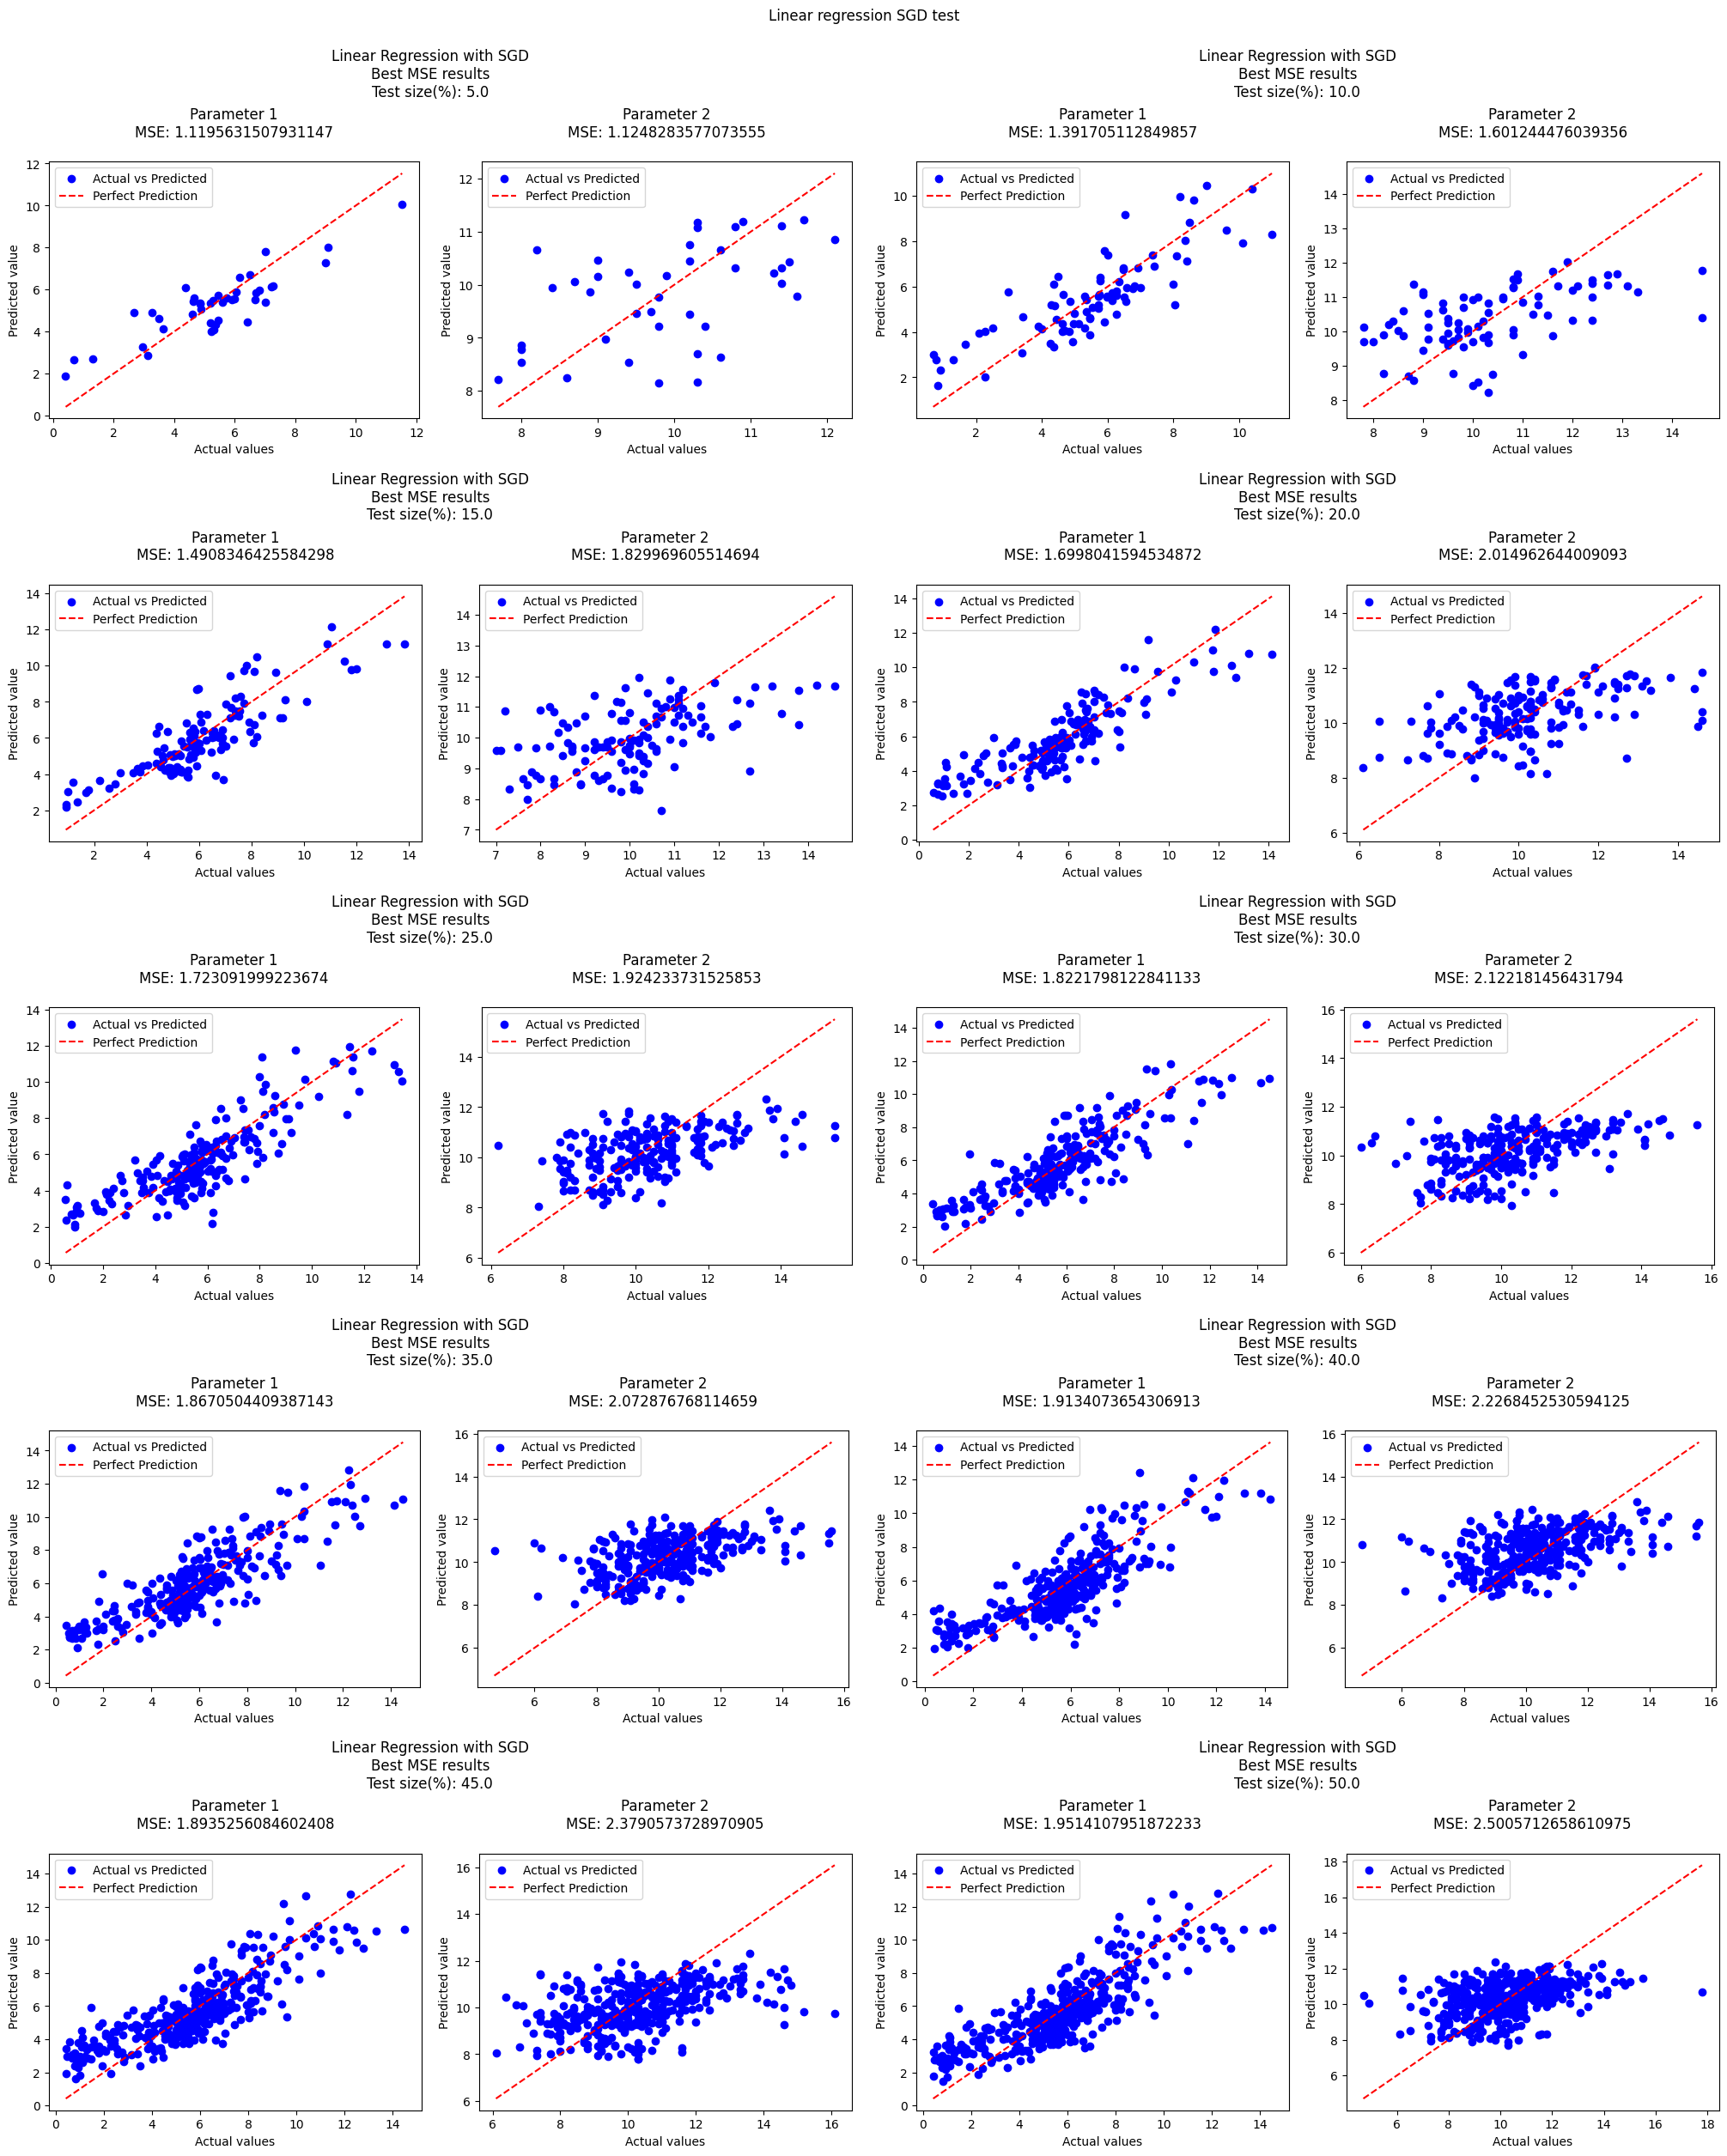

In [19]:

mlflow.set_experiment("Linear SGD Demetra")
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")

#number of trials
trials = 100
np.random.seed(42)
seeds = np.random.randint(trials, size=trials)

ripartitions = [i/100 for i in range(5,55,5)]
results = []  #["Ripartition", "Best_MSE1", "Best_MSE2","MSE1_mean","MSE2_mean","MSE1_var","MSE2_var"]

# create 5x2 subfigs
fig = plt.figure(constrained_layout=True, figsize=(20, 25))
fig.suptitle('Linear regression SGD test'+"\n")
subfigs = fig.subfigures(nrows=5, ncols=2).flatten()
k = 0

for ripartition in ripartitions:

    '''PARAM 1'''
    MSE_param1 = []
    best_MSE_1 = 100000000
    best_data_1 = {"Y_test":None, "Y_pred":None,"seed":None}

    '''PARAM 2'''
    MSE_param2 = []
    best_MSE_2 = 100000000
    best_data_2 = {"Y_test":None, "Y_pred":None,"seed":None}

    run_name = str(ripartition) + " ripartition"
    with mlflow.start_run(run_name=run_name):
        print("Ripartion: " + str(ripartition))
        i = 0
        mlflow.log_param('ripartition', ripartition)
        for i in range(trials):
            #Ripartition in training and test and
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,0], test_size=ripartition, random_state=seeds[i])
            sgd_reg = SGDRegressor(max_iter=5000, tol=1e-5, penalty=None, eta0=0.01,
            n_iter_no_change=10, random_state=42)
    
            # Train the model using the training sets
            sgd_reg.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_regr_sgd = sgd_reg.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param1.append(mean_squared_error(Y_test, Y_pred_regr_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param1[-1] < best_MSE_1:
              best_MSE_1 = MSE_param1[-1]
              best_data_1["Y_test"] = Y_test
              best_data_1["Y_pred"] = Y_pred_regr_sgd
              best_data_1["seed"] = seeds[i]
    
    
    
        i = 0
        for i in range(trials):
            X_train, X_test, Y_train, Y_test = train_test_split(X, Y[:,1], test_size=ripartition, random_state=seeds[i])
            sgd_reg = SGDRegressor(max_iter=5000, tol=1e-5, penalty=None, eta0=0.01,
            n_iter_no_change=10, random_state=42)
    
            # Train the model using the training sets
            sgd_reg.fit(X_train, Y_train)
    
            # Make predictions using the testing set
            Y_pred_regr_sgd = sgd_reg.predict(X_test)
    
            #save MSE of the first parameters
            MSE_param2.append(mean_squared_error(Y_test, Y_pred_regr_sgd))
    
            #check if this is the best model in terms of MSE
            if MSE_param2[-1] < best_MSE_2:
              best_MSE_2 = MSE_param2[-1]
              best_data_2["Y_test"] = Y_test
              best_data_2["Y_pred"] = Y_pred_regr_sgd
              best_data_2["seed"] = seeds[i]
                
        mlflow.log_metric("Best_MSE1", best_MSE_1)
        mlflow.log_metric("Best_MSE2", best_MSE_2)
        mlflow.log_metric("Mean_MSE1", np.mean(MSE_param1))
        mlflow.log_metric("Mean_MSE2", np.mean(MSE_param2))
        mlflow.log_metric("Var_MSE1", np.var(MSE_param1))
        mlflow.log_metric("Var_MSE2", np.var(MSE_param2))
        
    results.append([str(ripartition * 100), str(best_MSE_1), str(best_MSE_2),
                    (np.mean(MSE_param1)), str(np.mean(MSE_param2)), str(np.var(MSE_param1)), str(np.var(MSE_param2)),
                    best_data_1["seed"],best_data_2["seed"]])

    '''PLOT THE BEST MODELS'''
    subfigs[k].suptitle(
        "Linear Regression with SGD" + "\n" + "Best MSE results" + "\n" + f"Test size(%): {ripartition * 100}")
    # create 1x2 subplots per subfig
    axs = subfigs[k].subplots(nrows=1, ncols=2)
    axs[0].scatter(best_data_1["Y_test"], best_data_1["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[0].plot([min(best_data_1["Y_test"]), max(best_data_1["Y_test"])],
                [min(best_data_1["Y_test"]), max(best_data_1["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[0].legend()
    axs[0].set_xlabel("Actual values")
    axs[0].set_ylabel("Predicted value")
    axs[0].set_title("Parameter 1" + "\n" + "MSE: " + str(min(MSE_param1)) + "\n")

    axs[1].scatter(best_data_2["Y_test"], best_data_2["Y_pred"], c='blue', label='Actual vs Predicted')
    axs[1].plot([min(best_data_2["Y_test"]), max(best_data_2["Y_test"])],
                [min(best_data_2["Y_test"]), max(best_data_2["Y_test"])], '--', c='red', label='Perfect Prediction')
    axs[1].legend()
    axs[1].set_xlabel("Actual values")
    axs[1].set_ylabel("Predicted value")
    axs[1].set_title("Parameter 2" + "\n" + "MSE: " + str(min(MSE_param2)) + "\n")
    k += 1


'''SHOW RESULTS'''

headers = ["Test size(%)", "Best(MSE1)", "Best(MSE2)", "Mean(MSE1)", "Mean(MSE2)", "Var(MSE1)", "Var(MSE2)","Seed1","Seed2"]

print(tabulate(results, headers,  tablefmt="double_outline"))
